In [1]:
import fitz
import google.generativeai as genai
import os
from tqdm import tqdm
from openai import OpenAI, APIConnectionError
from PIL import Image
import io
from docx import Document
from docx.shared import Inches, Pt

/Users/juanfelipe/Proyectos/translator/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def parsear_pdf_con_metadata_de_imagen(ruta_pdf: str) -> list[dict]:
    """
    Abre un PDF y extrae el contenido de cada página, asociando el texto
    con una lista de imágenes. Cada imagen incluye sus datos binarios y
    sus coordenadas (bbox) en la página.

    Args:
        ruta_pdf: La ruta al archivo PDF.

    Returns:
        Una lista de diccionarios, donde cada uno representa una página.
    """
    contenido_por_pagina = []
    try:
        # Abrir el documento PDF
        with fitz.open(ruta_pdf) as doc:
            print(f"📄 Procesando el documento: '{ruta_pdf}' con {len(doc)} páginas.")
            
            # Iterar a través de cada página
            for numero_pagina, pagina in enumerate(doc, start=1):
                datos_pagina = {
                    "pagina_num": numero_pagina,
                    "texto": pagina.get_text("text"),
                    "imagenes": []
                }
                
                # Obtener la lista de todas las imágenes en la página
                lista_imagenes_pagina = pagina.get_images(full=True)
                
                for datos_imagen in lista_imagenes_pagina:
                    xref = datos_imagen[0]
                    
                    # Extraer los bytes de la imagen
                    imagen_dict = doc.extract_image(xref)
                    imagen_bytes = imagen_dict["image"]
                    
                    # Obtener las coordenadas (bbox) de la imagen en la página.
                    # get_image_rects devuelve una lista de rectángulos; tomamos el primero.
                    rectangulos_imagen = pagina.get_image_rects(xref)
                    if rectangulos_imagen:
                        bbox = rectangulos_imagen[0]  # fitz.Rect object
                        
                        # Crear un diccionario para la metadata de esta imagen
                        metadata_imagen = {
                            "bytes": imagen_bytes,
                            "bbox": (bbox.x0, bbox.y0, bbox.x1, bbox.y1) # Guardar como tupla
                        }
                        datos_pagina["imagenes"].append(metadata_imagen)
                
                contenido_por_pagina.append(datos_pagina)

    except Exception as e:
        print(f"❌ Ocurrió un error al procesar el archivo: {e}")
        return []

    return contenido_por_pagina

In [3]:
# --- Ejemplo de Uso ---
if __name__ == "__main__":
    # 1. Reemplaza "tu_documento.pdf" con la ruta a tu archivo.
    nombre_archivo = "Yuan Up - Chinese.pdf"
    
    # 2. Llamar a la función para obtener los chunks de texto.
    chunks_del_pdf = parsear_pdf_con_metadata_de_imagen(nombre_archivo)

📄 Procesando el documento: 'Yuan Up - Chinese.pdf' con 278 páginas.


In [4]:
def visualizar_imagenes_de_chunks(chunks_con_metadata: list[dict]):
    """
    Recorre la lista de chunks y muestra cada imagen encontrada en pantalla.
    """
    print("\n🖼️  Iniciando visualización de imágenes. Presiona Enter para continuar entre imágenes.")
    total_imagenes = sum(len(chunk['imagenes']) for chunk in chunks_con_metadata)
    
    if total_imagenes == 0:
        print("No se encontraron imágenes en el documento.")
        return

    contador_global = 0
    for chunk in chunks_con_metadata:
        if not chunk['imagenes']:
            continue # Salta las páginas sin imágenes

        for i, imagen_bytes in enumerate(chunk['imagenes']):
            contador_global += 1
            print(f"\nMostrando imagen {i + 1} de la página {chunk['pagina_num']} ({contador_global}/{total_imagenes})")
            
            try:
                # Usar io.BytesIO para tratar los bytes como un archivo en memoria
                imagen = Image.open(io.BytesIO(imagen_bytes))
                
                # .show() abre la imagen con el visor predeterminado del sistema
                imagen.show()

                # Pausa para que el usuario pueda ver la imagen antes de que aparezca la siguiente
                if contador_global < total_imagenes:
                    input("Presiona Enter para ver la siguiente imagen...")

            except Exception as e:
                print(f"  -> No se pudo abrir la imagen: {e}")
    
    print("\nVisualización completada.")

In [5]:
import matplotlib.pyplot as plt
# (El resto del código, como la función de parseo, es el mismo)

def visualizar_imagenes_con_matplotlib(chunks_con_metadata: list[dict]):
    """
    Recorre los chunks y muestra cada imagen en una ventana de Matplotlib,
    incluyendo sus coordenadas en el título.
    """
    print("\n📊 Iniciando visualización con Matplotlib.")
    print("Cierra la ventana de cada imagen para continuar con la siguiente.")

    total_imagenes = sum(len(chunk['imagenes']) for chunk in chunks_con_metadata)
    if total_imagenes == 0:
        print("No se encontraron imágenes para mostrar.")
        return

    for chunk in chunks_con_metadata:
        # La estructura de 'imagenes' es ahora una lista de diccionarios
        for i, imagen_meta in enumerate(chunk['imagenes']):
            # Accedemos a la clave 'bytes' para obtener los datos de la imagen
            img_bytes = imagen_meta['bytes']
            bbox = imagen_meta['bbox']
            
            try:
                # Abrir la imagen desde los bytes
                imagen_pil = Image.open(io.BytesIO(img_bytes))
                
                # Crear y mostrar la figura con Matplotlib
                plt.figure(figsize=(8, 6))
                plt.imshow(imagen_pil)
                
                # Título informativo que ahora incluye las coordenadas
                plt.title(f"Página {chunk['pagina_num']} - Imagen {i + 1}\nCoordenadas (BBox): {bbox}", fontsize=10)
                
                plt.axis('off')  # Ocultar los ejes
                plt.tight_layout()
                plt.show()  # Pausa la ejecución hasta que la ventana se cierre

            except Exception as e:
                print(f"  -> No se pudo mostrar la imagen {i+1} de la página {chunk['pagina_num']}. Error: {e}")

    print("\nVisualización completada.")


📊 Iniciando visualización con Matplotlib.
Cierra la ventana de cada imagen para continuar con la siguiente.


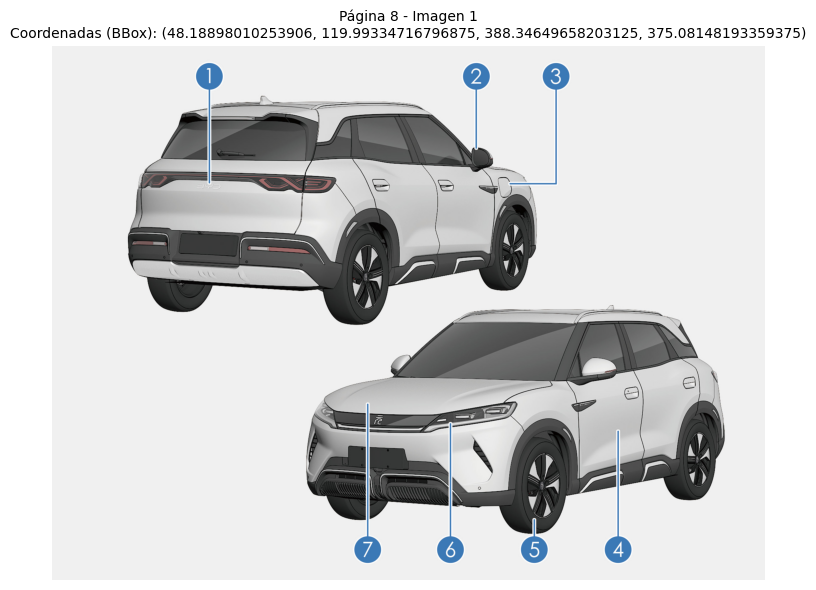

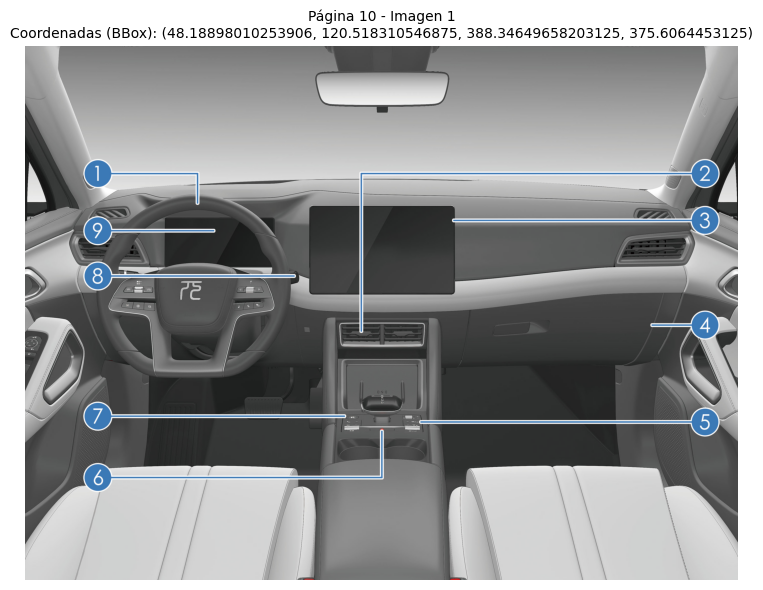


Visualización completada.


In [6]:
visualizar_imagenes_con_matplotlib(chunks_del_pdf[7:10])

In [7]:
img = chunks_del_pdf[9]["imagenes"]

In [8]:
def traducir_texto_local(texto_a_traducir: str) -> str:
    """
    Envía texto al modelo DeepSeek local a través de Ollama para traducirlo.

    Args:
        texto_a_traducir: El texto en español que se va a traducir.

    Returns:
        El texto traducido al inglés.
    """
    # Apuntar el cliente a nuestro servidor local de Ollama
    client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")


    try:
        # La instrucción para el modelo es clara y concisa
        chat_completion = client.chat.completions.create(
            model="deepseek-llm",  # El nombre del modelo que descargaste en Ollama
            messages=[
                {
                    "role": "system",
                    "content": "You are a professional translator. Translate the following text from Chinese to English. Reply only with the translated text, do not add comments nor explanations.",
                },
                {
                    "role": "user",
                    "content": texto_a_traducir,
                },
            ],
            temperature=0.1, # Usamos una temperatura baja para traducciones más directas
        )
        return chat_completion.choices[0].message.content.strip()
    
    except APIConnectionError as e:
        print("❌ Error de conexión: No se pudo conectar al servidor de Ollama en http://localhost:11434")
        print("Asegúrate de que Ollama esté corriendo y que hayas ejecutado 'ollama run deepseek-llm' previamente.")
        return "[TRADUCCIÓN FALLIDA]"
    except Exception as e:
        print(f"❌ Ocurrió un error inesperado durante la traducción: {e}")
        return "[TRADUCCIÓN FALLIDA]"

In [9]:
traducir_texto_local(chunks_del_pdf[0])

❌ Ocurrió un error inesperado durante la traducción: Error code: 400 - {'error': "Invalid 'content': 'content' field must be a string or an array of objects. Got 'object'."}


'[TRADUCCIÓN FALLIDA]'

In [10]:
def construir_word_completo_con_metodo_seguro(ruta_pdf: str, ruta_word_salida: str):
    """
    Orquesta la creación de un documento de Word a partir de un PDF, utilizando
    la estrategia de inserción secuencial de imágenes para cada página.
    """
    # 1. Parsear el PDF para obtener todos los chunks
    todos_los_chunks = parsear_pdf_con_metadata_de_imagen(ruta_pdf)
    if not todos_los_chunks:
        print("No se pudo extraer contenido del PDF. Abortando proceso.")
        return

    # 2. Crear un documento de Word en blanco
    doc = Document()
    print(f"\n📄 Creando el documento de Word final en: '{ruta_word_salida}'")

    # 3. Iterar sobre cada chunk (página)
    for i, chunk in enumerate(todos_los_chunks):
        print(f"\n--- Procesando Página {chunk['pagina_num']}/{len(todos_los_chunks)} ---", end="\r")

        # a. Traducir y añadir el texto de la página
        texto_traducido = traducir_texto_local(chunk['texto'])
        doc.add_heading(f"Contenido de la Página {chunk['pagina_num']}", level=1)
        doc.add_paragraph(texto_traducido)
        
        # b. Añadir las imágenes de la página de forma secuencial
        if chunk['imagenes']:
            doc.add_heading("Imágenes", level=2)
            for j, imagen_meta in enumerate(chunk['imagenes']):
                img_bytes = imagen_meta['bytes']
                x0, y0, x1, y1 = imagen_meta['bbox']
                
                # Calcular el ancho en pulgadas
                ancho_pulgadas = (x1 - x0) / 72.0
                
                # Prevenir anchos inválidos
                if ancho_pulgadas <= 0:
                    print(f"  -> ⚠️ ADVERTENCIA: Imagen {j+1} con ancho inválido. Saltando.")
                    continue
                
                try:
                    # Añadir la imagen desde el buffer de memoria
                    doc.add_picture(io.BytesIO(img_bytes), width=Inches(ancho_pulgadas))
                    doc.add_paragraph(f"Imagen {j+1}", style='Caption')
                except Exception as e:
                    print(f"  -> ⚠️ ADVERTENCIA: No se pudo insertar la imagen {j+1}. Error: {e}")
                    doc.add_paragraph(f"[Error al insertar la imagen {j+1}]", style='Caption')

        # c. Añadir un salto de página (excepto después de la última página)
        if i < len(todos_los_chunks) - 1:
            doc.add_page_break()

    # 4. Guardar el documento final
    try:
        doc.save(ruta_word_salida)
        print(f"\n\n🎉 ¡ÉXITO! El documento completo ha sido guardado en '{ruta_word_salida}'")
    except Exception as e:
        print(f"\n❌ Error al guardar el documento final: {e}")

In [11]:
doc_salida = "Yuan Up - English.docx"

In [12]:
construir_word_completo_con_metodo_seguro(nombre_archivo, doc_salida)

📄 Procesando el documento: 'Yuan Up - Chinese.pdf' con 278 páginas.

📄 Creando el documento de Word final en: 'Yuan Up - English.docx'

--- Procesando Página 1/278 ---
--- Procesando Página 2/278 ---
--- Procesando Página 3/278 ---
--- Procesando Página 4/278 ---
--- Procesando Página 5/278 ---
--- Procesando Página 6/278 ---
--- Procesando Página 7/278 ---
--- Procesando Página 8/278 ---
--- Procesando Página 9/278 ---
--- Procesando Página 10/278 ---
--- Procesando Página 11/278 ---
--- Procesando Página 12/278 ---
--- Procesando Página 13/278 ---
❌ Ocurrió un error inesperado durante la traducción: Error code: 400 - {'error': "'messages' array must only contain objects with a 'content' field that is not empty."}

--- Procesando Página 15/278 ---
--- Procesando Página 16/278 ---
--- Procesando Página 17/278 ---
--- Procesando Página 18/278 ---
--- Procesando Página 19/278 ---
--- Procesando Página 20/278 ---
--- Procesando Página 21/278 ---
--- Procesando Página 22/278 ---
--- Proces